<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-2-public/blob/adding_C3/C3/W1/ungraded_labs/C3_W1_Lab_1_tfds_hello_world.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TFDS Data Pipelines

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In this notebook we will take a look at the simple data pipelines scenario of TensorFlow Datasets (TFDS). We'll use TFDS to perform the extract, transform, and load processes for the MNIST dataset.

## Setup

We'll start by importing TensorFlow, TensorFlow Datasets, and Matplotlib.

In [ ]:
%%bash
pip install -qU pip wheel
pip install -qU tensorflow tensorflow_datasets
pip install -qU numpy pandas matplotlib seaborn

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
sns.set(font='DejaVu Sans')

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds

print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.9.1


In [3]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2022-05-27 00:12:19.685363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 00:12:19.691896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 00:12:19.692185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Extract - Transform - Load (ETL)

Now we'll run the **ETL** code. First, to perform the **Extract** process we use `tfts.load`. This handles everything from downloading the raw data to parsing and splitting it, giving us a dataset. Next, we perform the **Transform** process. In this simple example, our transform process will just consist of shuffling the dataset. Finally, we **Load** one record by using the `take(1)` method. In this case, each record consists of an image and its corresponding label. After loading the record we proceed to plot the image and print its corresponding label. 

In [2]:
# See available datasets
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'asset',
 'assin2',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'bee_dataset',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'booksum',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cardiotox',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19',
 'covid19sum',
 'crema_d',
 'cs_restaurants',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'd4rl_adroit_door',
 'd4rl_adr

In [3]:
# Pick dataset
mnist_builder = tfds.builder('mnist')
# Download
mnist_builder.download_and_prepare()
# Extract dataset
mnist_builder.as_dataset(split=tfds.Split.TRAIN)

2022-05-22 18:11:35.692743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-22 18:11:35.698386: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-22 18:11:35.698613: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-22 18:11:35.699814: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

<PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [4]:
dataset, info = tfds.load(name='mnist', with_info=True)
info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/home/meng/tensorflow_datasets/mnist/3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [5]:
num_train_examples = info.splits['train'].num_examples
num_test_examples = info.splits['test'].num_examples
num_classes = info.features['label'].num_classes
input_img_size_original = info.features['image'].shape[0]
input_img_shape_original = info.features['image'].shape

print("Number of train examples:", num_train_examples)
print("Number of test examples:", num_test_examples)
print("Number of label classes:", num_classes)
print("Input image size (original):", input_img_size_original)
print("Input image shape (original):", input_img_shape_original)

Number of train examples: 60000
Number of test examples: 10000
Number of label classes: 10
Input image size (original): 28
Input image shape (original): (28, 28, 1)


Label: [5]


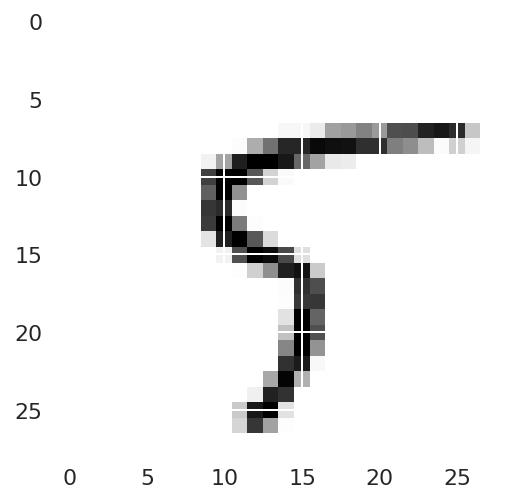

In [6]:
# EXTRACT
# Construct a tf.data.Dataset by downloading and extracting
dataset, info = tfds.load(name='mnist', split='train', with_info=True)
# Checking if the dataset is an instance of tf.data.Dataset
assert isinstance(dataset, tf.data.Dataset)

def normalize(elem):
    # Make image color values to be float
    elem['image'] = tf.cast(elem['image'], tf.float32)
    # Make image color values to be in [0..1] range.
    elem['image'] /= 255.0
    return elem

# TRANSFORM
# Normalize images
dataset = dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
# Cache before shuffling for a better performance
dataset = dataset.cache()
# Set the shuffle buffer to the full dataset size
dataset = dataset.shuffle(info.splits['train'].num_examples)
# Unique batches at each epoch
dataset = dataset.batch(1)
# End the pipeline by prefetching for performance
dataset = dataset.prefetch(tf.data.AUTOTUNE)

# LOAD
iterator = dataset.take(1) # To fetch 10 samples from the dataset
for data in iterator:
    image = data['image'].numpy().squeeze()
    label = data['label'].numpy()
    
    print("Label: {}".format(label))
    plt.imshow(image, cmap=plt.cm.binary)
    plt.show()

In [7]:
ds, info = tfds.load(name='mnist', split='train',
    as_supervised=True, with_info=True)
# Inspecting shapes of a batch
# tuples of data and label
ds = ds.cache()
ds = ds.shuffle(info.splits['train'].num_examples)
ds = ds.batch(128)
ds = ds.prefetch(tf.data.AUTOTUNE)
ds = ds.take(1)

for image, label in tfds.as_numpy(ds):
    print(image.shape, label.shape)

(128, 28, 28, 1) (128,)


## Fashion MNIST

In [8]:
(x_train, y_train), (x_test, y_test) = \
    tf.keras.datasets.fashion_mnist.load_data()

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (60000, 28, 28)
y_train shape: (60000,)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


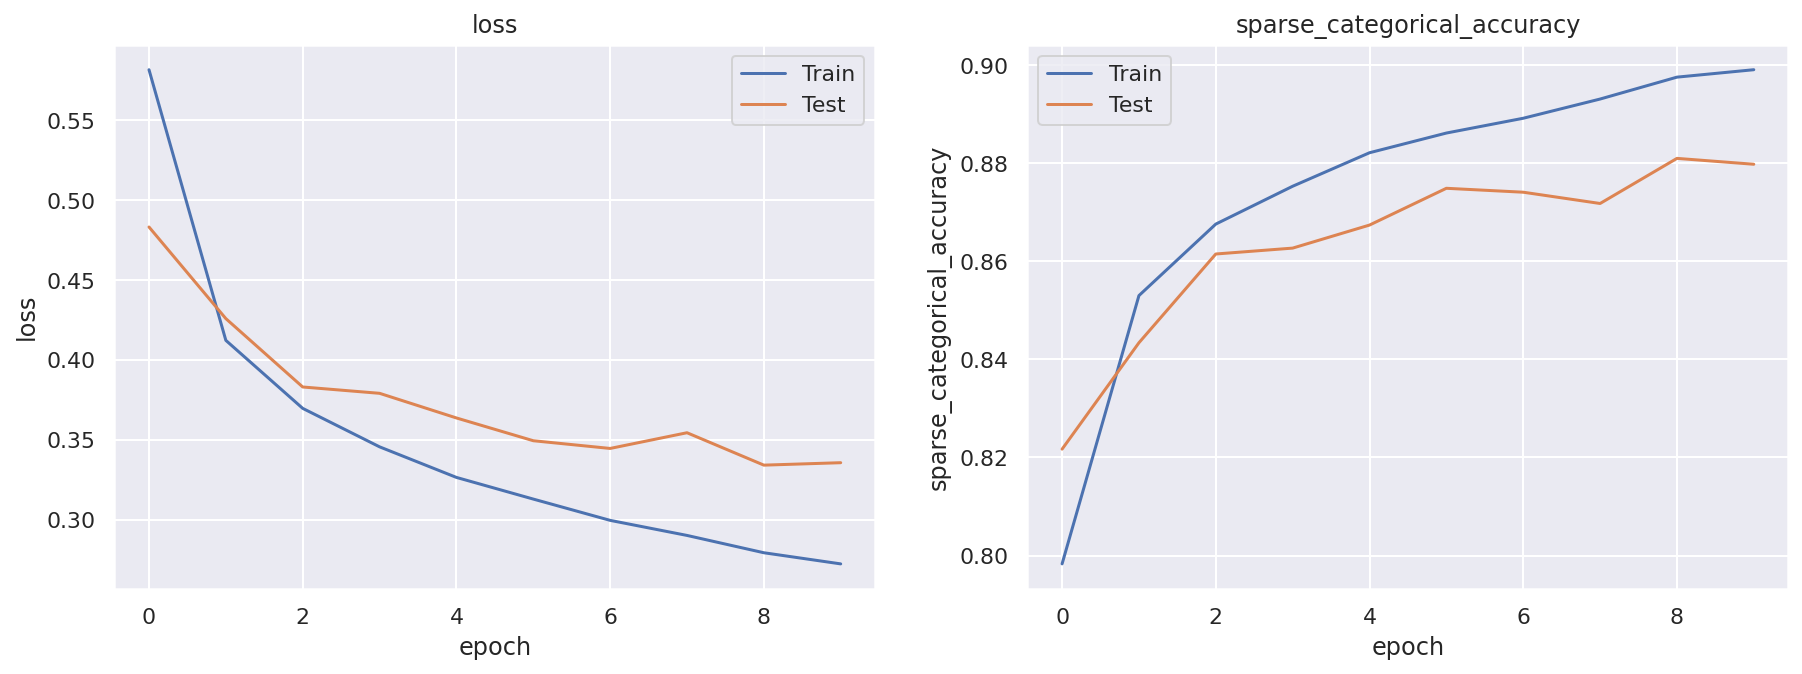

Test loss: 0.3358 
Test accuracy: 0.8798
True: [4 4 9]
Predict: [4 4 5]
Probability: [97.96922  96.022995 48.020344]


In [9]:
inputs = tf.keras.Input(shape=(28, 28, 1))
h = tf.keras.layers.Flatten()(inputs)
h = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(h)
h = tf.keras.layers.Dropout(0.1)(h)
outputs = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)(h)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model.summary()

(ds_train, ds_test), ds_info = tfds.load(name='fashion_mnist', 
        split=['train', 'test'], 
        as_supervised=True, with_info=True)

def normalize(x, y):
    return tf.cast(x, tf.float32) / 255., y

ds_train = ds_train.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

history = model.fit(ds_train, validation_data=ds_test,
    epochs=10, verbose=0)
history_df = pd.DataFrame(history.history, index=history.epoch)
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for metric, ax in zip(['loss', 'sparse_categorical_accuracy'], axs):
    sns.lineplot(ax=ax, data=history_df, x=history_df.index,
        y=metric, label='Train')
    sns.lineplot(ax=ax, data=history_df, x=history_df.index,
        y='val_' + metric, label='Test')
    ax.set_xlabel('epoch')
    ax.set_title(metric)
plt.show()

result = model.evaluate(ds_test, verbose=0)
print(f"Test loss: {result[0]:.4f} \n"
    f"Test accuracy: {result[1]:.4f}")

for x, y in tfds.as_numpy(ds_test.take(1)):
    x_test, y_test = x[:3], y[:3]
    predict = model.predict(x_test, verbose=0)
    print(f"True: {y_test}")
    print(f"Predict: {np.argmax(predict, axis=1)}")
    print(f"Probability: {100*np.max(predict, axis=1)}")

## Horses or Humans

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

2022-05-27 00:30:21.630004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 00:30:21.634864: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 00:30:21.635092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 00:30:21.635510: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

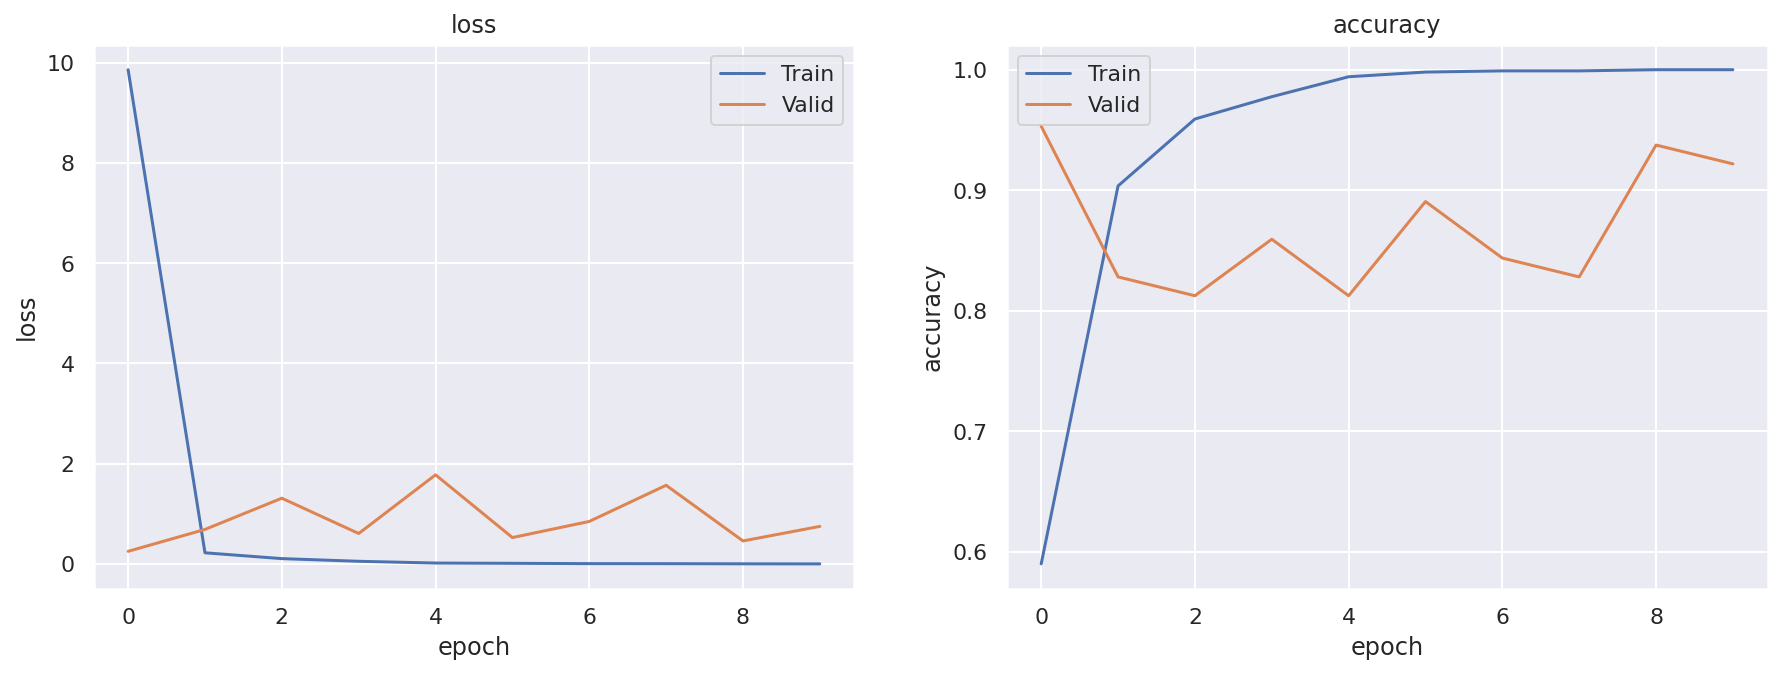

Test loss: 1.7547 
Test accuracy: 0.8672


In [2]:
# inputs = tf.keras.Input(shape=(300, 300, 3))
# h = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.nn.relu)(inputs)
# h = tf.keras.layers.MaxPooling2D(2, 2)(h)
# h = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu)(h)
# h = tf.keras.layers.MaxPooling2D(2, 2)(h)
# h = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu)(h)
# h = tf.keras.layers.MaxPooling2D(2, 2)(h)
# h = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu)(h)
# h = tf.keras.layers.MaxPooling2D(2, 2)(h)
# h = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu)(h)
# h = tf.keras.layers.MaxPooling2D(2, 2)(h)
# h = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu)(h)
# h = tf.keras.layers.MaxPooling2D(2, 2)(h)
# h = tf.keras.layers.Flatten()(h)
# h = tf.keras.layers.Dense(512, activation=tf.nn.relu)(h)
# outputs = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(h)

# model = tf.keras.Model(inputs=inputs, outputs=outputs)
# model.compile(optimizer=tf.keras.optimizers.Adam(), 
#     loss=tf.keras.losses.BinaryCrossentropy(),
#     metrics=[tf.keras.metrics.Accuracy()])

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                                      input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

(ds_train, ds_test), ds_info = tfds.load(name='horses_or_humans',
    split=['train', 'test'], as_supervised=True, with_info=True)

# def normalize(x, y):
#     return tf.cast(x, tf.float32) / 255., y

# ds_train = ds_train.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(64)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

# ds_test = ds_test.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(64)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

history = model.fit(ds_train, validation_data=ds_test, validation_steps=1, 
    epochs=10, verbose=0)
history_df = pd.DataFrame(history.history, index=history.epoch)
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for metric, ax in zip(['loss', 'accuracy'], axs):
    sns.lineplot(ax=ax, data=history_df, x=history_df.index, 
        y=metric, label='Train')
    sns.lineplot(ax=ax, data=history_df, x=history_df.index,
        y='val_' + metric, label='Valid')
    ax.set_xlabel('epoch')
    ax.set_title(metric)
plt.show()

result = model.evaluate(ds_test, verbose=0)
print(f"Test loss: {result[0]:.4f} \n"
    f"Test accuracy: {result[1]:.4f}")

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

data = tfds.load('horses_or_humans', split='train', as_supervised=True)
val_data = tfds.load('horses_or_humans', split='test', as_supervised=True)

2022-05-27 00:23:34.483405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 00:23:34.488169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 00:23:34.488387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 00:23:34.489033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
train_batches = data.shuffle(100).batch(32)
validation_batches = val_data.batch(32)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                                      input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [3]:
history = model.fit(train_batches, epochs=10, 
    validation_data=validation_batches, validation_steps=1)

Epoch 1/10


2022-05-27 00:24:31.065230: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


33/33 [==============================] - 5s 78ms/step - loss: 5.6502 - accuracy: 0.7566 - val_loss: 0.3130 - val_accuracy: 0.8438
Epoch 2/10
 3/33 [=>............................] - ETA: 1s - loss: 0.1105 - accuracy: 0.9896

2022-05-27 00:24:35.136664: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


33/33 [==============================] - 2s 60ms/step - loss: 0.1169 - accuracy: 0.9649 - val_loss: 0.5511 - val_accuracy: 0.8438
Epoch 3/10
 3/33 [=>............................] - ETA: 1s - loss: 0.0854 - accuracy: 0.9479

2022-05-27 00:24:37.125165: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


33/33 [==============================] - 2s 58ms/step - loss: 0.0426 - accuracy: 0.9825 - val_loss: 0.3486 - val_accuracy: 0.8750
Epoch 4/10
 3/33 [=>............................] - ETA: 1s - loss: 0.0173 - accuracy: 0.9896

2022-05-27 00:24:39.063275: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


33/33 [==============================] - 2s 59ms/step - loss: 0.0119 - accuracy: 0.9961 - val_loss: 0.5911 - val_accuracy: 0.8438
Epoch 5/10
 3/33 [=>............................] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

2022-05-27 00:24:41.027725: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


33/33 [==============================] - 2s 60ms/step - loss: 9.5742e-04 - accuracy: 1.0000 - val_loss: 0.4923 - val_accuracy: 0.8750
Epoch 6/10
 3/33 [=>............................] - ETA: 1s - loss: 3.2117e-04 - accuracy: 1.0000

2022-05-27 00:24:42.995398: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


33/33 [==============================] - 2s 59ms/step - loss: 2.8813e-04 - accuracy: 1.0000 - val_loss: 0.6376 - val_accuracy: 0.8438
Epoch 7/10
 3/33 [=>............................] - ETA: 1s - loss: 1.4884e-04 - accuracy: 1.0000

2022-05-27 00:24:44.948384: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


33/33 [==============================] - 2s 59ms/step - loss: 1.7661e-04 - accuracy: 1.0000 - val_loss: 0.6720 - val_accuracy: 0.8438
Epoch 8/10
 3/33 [=>............................] - ETA: 1s - loss: 1.1700e-04 - accuracy: 1.0000

2022-05-27 00:24:46.910930: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


33/33 [==============================] - 2s 59ms/step - loss: 1.2420e-04 - accuracy: 1.0000 - val_loss: 0.6991 - val_accuracy: 0.8438
Epoch 9/10
 3/33 [=>............................] - ETA: 1s - loss: 1.2215e-04 - accuracy: 1.0000

2022-05-27 00:24:48.862112: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


33/33 [==============================] - 2s 60ms/step - loss: 9.1519e-05 - accuracy: 1.0000 - val_loss: 0.7508 - val_accuracy: 0.8438
Epoch 10/10
 3/33 [=>............................] - ETA: 1s - loss: 9.4722e-05 - accuracy: 1.0000

2022-05-27 00:24:50.847999: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


33/33 [==============================] - 2s 58ms/step - loss: 7.1420e-05 - accuracy: 1.0000 - val_loss: 0.7617 - val_accuracy: 0.8438


2022-05-27 00:24:52.776831: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
